In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import gradio as gr

c:\Users\blubo\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
inputChannels = 3
NDF = 64 #num discriminator features
#DEFINE MODEL

def initilize_weights(layer):
  layer_name = layer.__class__.__name__
  if layer_name.find("Conv") != -1:
    nn.init.normal_(layer.weight.data, 0, 0.02)
  if layer_name.find("BatchNorm") != -1:
    nn.init.normal_(layer.weight.data, 1, 0.02)
    nn.init.constant_(layer.bias.data, 0)

noiseChannels = 100
NGF = 64
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.block1 = nn.Sequential(nn.ConvTranspose2d(noiseChannels, NGF*8, 4, 1, 0, bias = False), nn.BatchNorm2d(NGF*8), nn.ReLU())
    self.block2 = nn.Sequential(nn.ConvTranspose2d(NGF*8, NGF*4, 4, 2, 1, bias = False), nn.BatchNorm2d(NGF*4), nn.ReLU(), nn.Conv2d(NGF*4, NGF*4, 3, 1, 1, bias = False), nn.BatchNorm2d(NGF*4), nn.ReLU())
    self.block3 = nn.Sequential(nn.ConvTranspose2d(NGF*4, NGF*2, 4, 2, 1, bias = False), nn.BatchNorm2d(NGF*2), nn.ReLU(), nn.Conv2d(NGF*2, NGF*2, 3, 1, 1, bias = False), nn.BatchNorm2d(NGF*2), nn.ReLU())
    self.block4 = nn.Sequential(nn.ConvTranspose2d(NGF*2, NGF, 4, 2, 1, bias = False), nn.BatchNorm2d(NGF), nn.ReLU(), nn.Conv2d(NGF, NGF, 3, 1, 1, bias = False), nn.BatchNorm2d(NGF), nn.ReLU())
    self.block5 = nn.Sequential(nn.ConvTranspose2d(NGF, inputChannels, 4, 2, 1, bias = False), nn.Tanh())

  def forward(self, x):
    x = self.block1(x)
    #print("GEN", x.shape)
    x = self.block2(x)
    #print("GEN", x.shape)
    x = self.block3(x)
    #print("GEN", x.shape)
    x = self.block4(x)
    #print("GEN", x.shape)
    x = self.block5(x)
    #print("-------------------------")
    return x
  
class SuperRes(nn.Module):
  def __init__(self):
    super(SuperRes, self).__init__()

    self.layer1 = nn.Sequential(
      nn.ConvTranspose2d(3, 16, 4, 2, 1),
      nn.LeakyReLU(0.2),
    )

    self.layer2 = nn.Sequential(
      nn.ConvTranspose2d(16, 32, 4, 2, 1),
      nn.LeakyReLU(0.2),
    )

    self.layer3 = nn.Sequential(
      nn.ConvTranspose2d(32, 64, 4, 2, 1),
      nn.LeakyReLU(0.2),
    )

    self.layer4 = nn.Sequential(
      nn.ConvTranspose2d(64, 3, 4, 2, 1),
      nn.Tanh()
    )

  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

device = "cuda"
res = SuperRes().to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(res.parameters())

In [6]:
noiseChannels = 100
genModel = torch.load("./genSave.model")
resModel = torch.load("./superresSave.model")

In [17]:
output = (genModel(torch.randn(1, noiseChannels, 1, 1, device = "cuda")).cpu().detach()[0].permute([1, 2, 0]) + 1) / 2

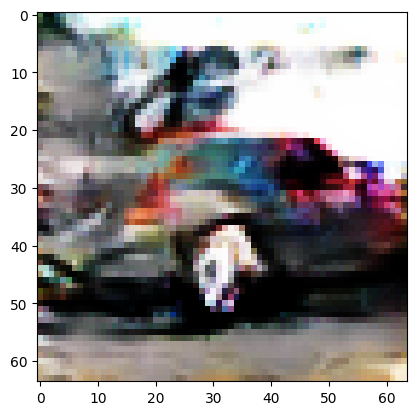

In [18]:
plt.imshow(output)

In [19]:
output.shape

torch.Size([64, 64, 3])

In [20]:
output = output.permute(2, 0, 1)
output = output.unsqueeze(0)
output = output.to("cuda")
output = resModel(output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


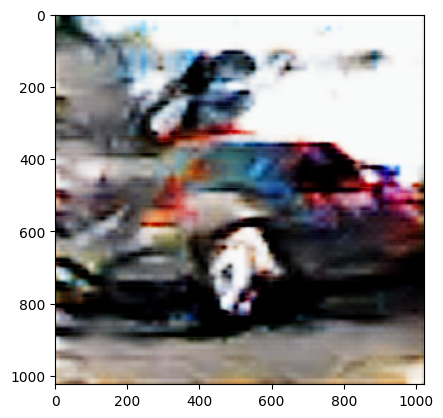

In [25]:
plt.imshow(output.detach().cpu().squeeze(0).permute(1, 2, 0))